## Bidirectional Encoder Representations from Transformers (BERT)

The following code downloads and fits the pretrained BERT model for the fake news detection task using the LIAR dataset. The steps involved are:
1. Load and preprocess the data.
2. Download the pretrained model using tensorflow hub and implement a function to perform BERT tokenization.
3. Initialize a dataloader that will effectively load the data into the model and use an ADAM optimizer to optimize the model parameters.
4. A `train_epoch` and `evaluate_epoch` function that will train the BERT model on batches of train data and evaluates the performance for each epoch.
5. Final code cells to print the confusion matrix and classification report to evaluate our model performance.

### 1. Loading and preprocessing data
This code cell is designed to load, preprocess, and analyze a dataset, presumably for a machine learning task related to text classification. It begins by defining two functions: `load_and_preprocess_data` and `preprocess_data`. The first function loads data from a file, and assigns specified column names. The second function preprocesses this data by creating a binary label based on certain conditions. For the sake of our project, we assigned "true" and "mostly-true" classes as 1, and the rest of the classes as 0. This will help us in our binary classification task. The function also removes certain columns, combines multiple metadata columns into a single column, and then appends this metadata to the text statements. After defining these functions, the code loads training, testing, and validation datasets from specified file paths and applies the preprocessing steps. Finally, it calculates and prints the count of positive and negative class labels in each dataset, providing an overview of the class distribution in the training, testing, and validation sets. This is useful for understanding the balance of classes in the data, which is crucial for training effective machine learning models.

In [ ]:
# This code cell performs the following operations:
import pandas as pd

def load_and_preprocess_data(filepath, column_names):
    data = pd.read_csv(filepath, sep="\t", header=None)
    data.columns = column_names
    return data

def preprocess_data(data):
    data['label_to_predict'] = data['label'].apply(lambda x: 1 if x in ["true", "mostly-true"] else 0)
    data = data.drop(['ID', 'label', 'barely_true_count', 'false_count', 'half_true_count', 'mostly_true_count', 'pants_on_fire_count'], axis=1)

    # Combining metadata into a single column
    metadata_columns = ['subject', 'speaker', 'speaker_job_title', 'state_info', 'party_affiliation', 'statement_context']
    data['metadata'] = data[metadata_columns].fillna('None').agg(' '.join, axis=1)

    # Final sentence column
    data['sentence'] = data['metadata'] + " " + data['statement']
    return data.dropna()

def print_class_counts(datasets):
    for name, dataset in datasets.items():
        neg_count = len(dataset[dataset['label_to_predict'] == 0])
        pos_count = len(dataset[dataset['label_to_predict'] == 1])
        print(f'Count of negative class values in {name} data = {neg_count}')
        print(f'Count of positive class values in {name} data = {pos_count}')

# Column names
column_names = ['ID', 'label', 'statement', 'subject', 'speaker', 'speaker_job_title', 'state_info', 'party_affiliation', 'barely_true_count', 'false_count', 'half_true_count', 'mostly_true_count', 'pants_on_fire_count', 'statement_context']

# Load and preprocess data
train_data = load_and_preprocess_data('/content/drive/MyDrive/Foundations of Data Science/Project/Data/train.tsv', column_names)
test_data = load_and_preprocess_data('/content/drive/MyDrive/Foundations of Data Science/Project/Data/test.tsv', column_names)
validation_data = load_and_preprocess_data('/content/drive/MyDrive/Foundations of Data Science/Project/Data/valid.tsv', column_names)

# Apply preprocessing
cleaned_train_data = preprocess_data(train_data)
cleaned_test_data = preprocess_data(test_data)
cleaned_val_data = preprocess_data(validation_data)

# Print class counts
print_class_counts({'train': cleaned_train_data, 'test': cleaned_test_data, 'validation': cleaned_val_data})

Count of negative class values in train data = 4207
Count of positive class values in train data = 2517
Count of negative class values in test data = 531
Count of positive class values in test data = 322
Count of negative class values in validation data = 564
Count of positive class values in validation data = 297


### 2. Setting up text data for BERT training

This code cell sets up a BERT (Bidirectional Encoder Representations from Transformers) model for sequence classification, specifically for a binary classification task. It initializes the model and tokenizer from the pre-trained 'bert-base-uncased' model with `num_labels=2` as we are modelling a binary classification task. The model is then moved to GPU for efficient computation, if a GPU is available. A custom function, bert_tokenization, is defined to tokenize datasets using the BERT tokenizer. This function takes a dataset and an optional argument to decide whether to use additional metadata or just the statement text. It processes each sentence in the dataset to generate BERT's input IDs and attention masks, which are required for the model to understand which parts of the input are meaningful and should be focused on. These are then converted into PyTorch tensors, suitable for input to the BERT model. Finally, the function tokenizes the training, testing, and validation datasets prepared earlier, resulting in tensors of input IDs, attention masks, and labels for each set, ready for use in training and evaluating the BERT model. This setup is a typical workflow for preparing text data for training with a pre-trained transformer model in natural language processing tasks.

**BERT's Input IDs:**

Input IDs are a fundamental component of BERT's preprocessing of text data. Each input ID is a numerical representation of a token in the BERT tokenizer's vocabulary. When a sentence is processed, the BERT tokenizer first splits the text into tokens (words or subwords), then maps each token to its corresponding ID based on the tokenizer's vocabulary. This conversion is crucial because neural networks, including BERT, operate on numerical data rather than raw text. The sequence of input IDs thus represents the sequence of tokens in the original sentence. Additionally, special tokens are added: `[CLS]` at the beginning of each sequence, which is used for classification tasks, and `[SEP]` to separate different sentences or to mark the end of a single sentence.

**BERT's Attention Masks:**

Attention masks in BERT serve the purpose of informing the model which parts of the input are actual data and which are padding. This distinction is necessary because, in batch processing, all input sequences need to be of the same length. To achieve this, sequences shorter than the maximum length are padded with a special token (`[PAD]`). However, these padding tokens should not influence the model's understanding of the actual content. Attention masks are binary (0 or 1) sequences where 1 indicates a real token and 0 indicates a padding token. During the model's processing, the attention mechanism can use these masks to focus only on the relevant parts of the input, effectively ignoring the padding. This ensures that the variable length of input texts does not affect the model's performance and allows BERT to handle inputs of varying lengths effectively.

In [ ]:
# This code cell performs the following operations:
from transformers import BertForSequenceClassification, BertTokenizer, AdamW
import torch

# Initialize BERT model
bert_model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)

bert_model.cuda()  # Move model to GPU if available

# Function for BERT tokenization
def bert_tokenization(dataset, use_metadata=False):
    sentences = dataset["sentence" if use_metadata else "statement"].values
    labels = dataset["label_to_predict"].values
    max_length = 256

    # Tokenization and data preparation
    input_ids = []
    attention_masks = []

    for sent in sentences:
        encoded_dict = bert_tokenizer.encode_plus(
            str(sent),
            add_special_tokens=True,
            max_length=max_length,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True,
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert lists into tensors
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)

    return input_ids, attention_masks, labels

# Tokenize datasets
train_input_ids, train_attention_masks, train_labels = bert_tokenization(cleaned_train_data)
test_input_ids, test_attention_masks, test_labels = bert_tokenization(cleaned_test_data)
val_input_ids, val_attention_masks, val_labels = bert_tokenization(cleaned_val_data)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


### 3. Setting up dataloaders for the BERT model

This code cell is focused on setting up data loaders for the BERT model and configuring the training process. First, it defines a function create_dataloader to create a DataLoader for a given dataset, which automates the process of batching, shuffling (for training data), and organizing the data for efficient processing. TensorDatasets for training, validation, and testing are created by combining the respective input IDs, attention masks, and labels into a single dataset. These datasets are then passed into the create_dataloader function with a specified batch size to create DataLoaders for each dataset. This setup allows for efficient iteration over the dataset during training and evaluation. Furthermore, the code configures an optimizer (AdamW) with specific learning rate and epsilon values for the training process. It also sets up a learning rate scheduler (get_linear_schedule_with_warmup) to adjust the learning rate during training, which is a common practice to improve training efficiency and model performance. The total number of training steps is calculated based on the number of epochs and the length of the training DataLoader, ensuring that the learning rate scheduler is appropriately scaled for the duration of the training process.

In [ ]:
# This code cell performs the following operations:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from transformers import get_linear_schedule_with_warmup

# Function to create DataLoader
def create_dataloader(dataset, batch_size, is_train=True):
    sampler = RandomSampler(dataset) if is_train else SequentialSampler(dataset)
    return DataLoader(dataset, sampler=sampler, batch_size=batch_size)

# Combine the training inputs into a TensorDataset.
bert_train_dataset = TensorDataset( train_input_ids, train_attention_masks, train_labels)

# Combine the validation inputs into a TensorDataset.
bert_val_dataset = TensorDataset(val_input_ids,val_attention_masks,val_labels)

# Combine the test inputs into a TensorDataset.
bert_test_dataset = TensorDataset(test_input_ids,test_attention_masks,test_labels)
# DataLoaders for train, validation, and test datasets
batch_size = 16
train_dataloader = create_dataloader(bert_train_dataset, batch_size, is_train=True)
validation_dataloader = create_dataloader(bert_val_dataset, batch_size, is_train=False)
test_dataloader = create_dataloader(bert_test_dataset, batch_size, is_train=False)

# Optimizer and Scheduler setup
learning_rate = 2e-5
epsilon = 1e-2
optimizer = AdamW(bert_model.parameters(), lr=learning_rate, eps=epsilon)

epochs = 5
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


### 4. Training and evaluating the model

This code cell implements the training and evaluation process for a BERT model on a given dataset. The training is conducted over a specified number of epochs, where each epoch represents a complete pass over the entire training dataset. The train_epoch function is defined to handle the training for one epoch. Within this function, the model is set to training mode, and then iterates over batches of data from the training DataLoader. For each batch, it loads the input IDs, attention masks, and labels onto the designated device (GPU if available, otherwise CPU). The model's gradients are reset to zero at the beginning of processing each batch to prevent accumulation from previous iterations. The model then performs a forward pass with the input data and computes the loss. This loss is used to perform a backward pass, calculating the gradients for each model parameter. Finally, the optimizer updates the model's weights based on these gradients. The average loss across all batches is computed and returned for monitoring the training progress.

The evaluate_model function is used to assess the model's performance on the validation set. The model is set to evaluation mode, which disables gradient calculations and certain layers like dropout, making the model more consistent and less prone to randomness in its predictions. The function iterates over the validation DataLoader, and for each batch, it performs a forward pass without gradient calculation to obtain the model's predictions (logits). These logits, which are the raw output scores for each class, are detached from the computation graph and converted to a NumPy array for further processing. The true labels are also gathered in a similar manner. The function then returns the aggregated predictions and true labels for all batches. After each training epoch, the model is evaluated on the validation set, and the results, including a classification report and confusion matrix, are printed out. This provides insights into the model's performance, such as its accuracy, precision, recall, and F1 score for each class, as well as how well it distinguishes between classes.

In [ ]:
# This code cell performs the following operations:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import torch

# Function for training a single epoch
def train_epoch(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0

    for batch in dataloader:
        batch_input_ids = batch[0].to(device)
        batch_attention_mask = batch[1].to(device)
        batch_labels = batch[2].to(device)

        # Clears old gradients from the last step (if they exist). This is crucial because by default, gradients are accumulated in PyTorch.
        model.zero_grad()
        outputs = model(batch_input_ids, token_type_ids=None, attention_mask=batch_attention_mask, labels=batch_labels)
        loss = outputs.loss
        total_loss += loss.item()

        '''
        loss.backward()
        This computes the gradient of the loss with respect to the model parameters. These gradients are used to update the model weights.

        optimizer.step()
        This updates the model's parameters based on the gradients calculated during the backward pass.
        '''
        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(dataloader)
    return avg_loss

# Function for evaluating the model
def evaluate_model(model, dataloader, device):
    model.eval()
    predictions, true_labels = [], []

    # Tells pytorch not to compute and store gradients
    with torch.no_grad():
        for batch in dataloader:
            batch_input_ids = batch[0].to(device)
            batch_attention_mask = batch[1].to(device)
            batch_labels = batch[2].to(device)

            outputs = model(batch_input_ids, token_type_ids=None, attention_mask=batch_attention_mask)

            # The logits are the raw, unnormalized scores output by the model for each class.
            logits = outputs.logits

            # The logits are detached from the current computation graph (to prevent gradient calculations) and moved to the CPU as a NumPy array.
            logits = logits.detach().cpu().numpy()

            # Similarly, the true labels are moved to the CPU as a NumPy array.
            label_ids = batch_labels.to('cpu').numpy()

            predictions.append(logits)
            true_labels.append(label_ids)

    predictions = np.concatenate(predictions, axis=0)
    true_labels = np.concatenate(true_labels, axis=0)
    return predictions, true_labels

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model.to(device)

for epoch in range(epochs):
    avg_train_loss = train_epoch(bert_model, train_dataloader, optimizer, device)
    print(f"Epoch {epoch + 1}/{epochs} - Training loss: {avg_train_loss:.4f}")

    # Evaluation on the validation set
    predictions, true_labels = evaluate_model(bert_model, validation_dataloader, device)
    predictions = np.argmax(predictions, axis=1)

    print("Validation Results")
    cls_report = classification_report(true_labels, predictions, output_dict=True)
    conf_matrix = confusion_matrix(true_labels, predictions)
    print(cls_report)
    print(conf_matrix)


Epoch 1/5 - Training loss: 0.6729
Validation Results
{'0': {'precision': 0.6565774155995343, 'recall': 1.0, 'f1-score': 0.7926914968376669, 'support': 564}, '1': {'precision': 1.0, 'recall': 0.006734006734006734, 'f1-score': 0.013377926421404682, 'support': 297}, 'accuracy': 0.6573751451800233, 'macro avg': {'precision': 0.8282887077997672, 'recall': 0.5033670033670034, 'f1-score': 0.4030347116295358, 'support': 861}, 'weighted avg': {'precision': 0.775040258302134, 'recall': 0.6573751451800233, 'f1-score': 0.5238690457184684, 'support': 861}}
[[564   0]
 [295   2]]
Epoch 2/5 - Training loss: 0.6569
Validation Results
{'0': {'precision': 0.6558139534883721, 'recall': 1.0, 'f1-score': 0.7921348314606742, 'support': 564}, '1': {'precision': 1.0, 'recall': 0.003367003367003367, 'f1-score': 0.006711409395973153, 'support': 297}, 'accuracy': 0.6562137049941928, 'macro avg': {'precision': 0.827906976744186, 'recall': 0.5016835016835017, 'f1-score': 0.3994231204283237, 'support': 861}, 'weigh

This code cell generates a heatmap visualization of the confusion matrix obtained from evaluating a BERT model. The confusion matrix is a useful tool in classification tasks to understand the performance of a model, showing how the predicted class labels compare to the true class labels. The heatmap, created using Seaborn's heatmap function, displays the number of instances for each combination of predicted and actual class labels, providing a clear and intuitive visual representation of where the model is performing well and where it is making errors. The labels 'Predicted' and 'Truth' on the x-axis and y-axis help identify the model's predictions versus the actual labels. This kind of visualization is helpful for quickly assessing the accuracy and error patterns of a classification model.

Text(50.722222222222214, 0.5, 'Truth')

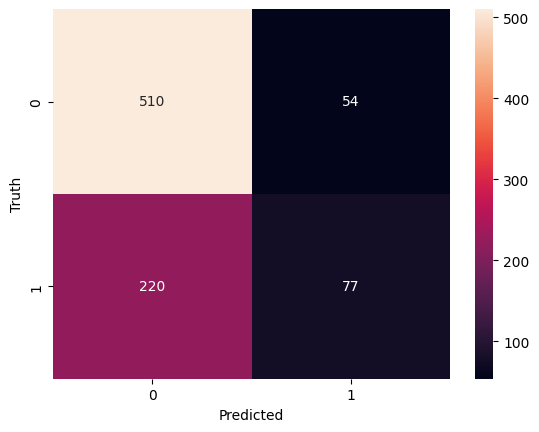

In [ ]:
# This code cell performs the following operations:
from matplotlib import pyplot as plt
import seaborn as sn

sn.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

This code cell prints the classification report of the model in a tabular format. A classification report in data science is a summary of the performance metrics for a classification model. It typically includes precision (the ratio of correctly predicted positive observations to the total predicted positives), recall or sensitivity (the ratio of correctly predicted positive observations to all actual positives), F1 score (a weighted average of precision and recall), and support (the number of actual occurrences of each class). Additionally, it often presents the overall accuracy of the model. These metrics provide a comprehensive view of a model's performance, highlighting its strengths and weaknesses in predicting different classes, and are essential for evaluating and fine-tuning classification algorithms, especially in cases where the dataset might be imbalanced or where certain types of prediction errors are more consequential than others.

In [ ]:
# This code cell performs the following operations:
import ast
report_df = pd.DataFrame(cls_report).transpose()

print(report_df)

              precision    recall  f1-score     support
0              0.698630  0.904255  0.788253  564.000000
1              0.587786  0.259259  0.359813  297.000000
accuracy       0.681765  0.681765  0.681765    0.681765
macro avg      0.643208  0.581757  0.574033  861.000000
weighted avg   0.660395  0.681765  0.640464  861.000000
